### **RISCO DE FOGO: QUEIMADAS NO CERRADO**
<hr>
<p align="justify">
Este trabalho é referente as tarefas desenvolvidas no Bloco 3. Espera-se desenvolver um projeto capaz de utilizar os comandos aprendidos pela linguagem de programação Python, na disciplina de Aprendizado de Máquina, além de desenvolver um sistema de previsão através de Machine Learning. Neste bloco, estamos aprimorando os processos de treino do modelo.
O grupo desenvolvedor é composto pelas discentes:
<p align="justify">
Isabela Bento Beneti </p>
<p align="justify">
Monyque Karoline de Paula Silva </p>
<p align="justify">
Sofia Baccega C.C. de Oliveira </p>
<p align="justify">
Sophia Figueiredo Michel </p>
<hr>

### **Início:**
<p align="justify">
Em um primento momento, iremos demonstrar o processo de tratamento dos dados obtidos via Database do INPE a respeito dos focos de incêndio ocorridos no Cerrado durante o período Janeiro-Julho(2022). É necessário realizar as padronizações de bibliotecas inicias, como a Pandas, Seaborn e Matplotlib, posteriormente, trabalha-se os dados até a otimização destes para a análise dos atríbutos escolhidos.
</p>

### **COLETA DE DADOS**

In [107]:
#importando bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree, utils, preprocessing
from itertools import product
from matplotlib import pyplot as plt


In [108]:
#Dados do Cerrado Brasileiro, armazenados mensalmente via .csv
arquivos = ['janeiro.csv','fev.csv','marco.csv','abril.csv','maio.csv','junho.csv','julho.csv']
def read_csv(list_of_files):
    dfs = []
    for x in list_of_files:
        file = pd.read_csv(x, sep=',')
        dfs.append(file)
    df = pd.concat(dfs).reset_index(drop=True)
        
    return df
meses = read_csv(arquivos)


In [109]:
#Dados trabalhados para a eliminação de NaN nas colunas e identificação dos tipos de dados
meses.convert_dtypes()
meses.dropna(how='any', inplace=True)
meses.drop(columns=['Unnamed: 0','estado', 'satelite', 'municipio', 'pais', 'municipio_id', 'estado_id', 'pais_id', 'bioma','data_hora_gmt'], axis = 1, inplace=True)
meses_fogo = meses['risco_fogo'] > 0
meses = meses[meses_fogo]
meses = meses.reset_index()
del meses['index']
display(meses)

,lat,lon,numero_dias_sem_chuva,precipitacao,risco_fogo
0,-12.314859,-43.234066,9.0,2.7,1.0
1,-20.227880,-46.415940,8.0,0.0,0.3
2,-20.229250,-46.426820,8.0,0.0,0.3
3,-20.238930,-46.425510,8.0,0.0,0.4
4,-20.237550,-46.414600,8.0,0.0,0.4
...,...,...,...,...,...
265136,-6.360000,-45.670000,46.0,0.0,1.0
265137,-6.360000,-45.690000,46.0,0.0,1.0
265138,-6.400000,-44.140000,34.0,0.0,1.0
265139,-6.350000,-45.670000,46.0,0.0,1.0


## Análise PCA 

In [110]:
# importando bibliotecas necessárias
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [111]:
# estabelecendo as features
FEATURES = [ "numero_dias_sem_chuva", "precipitacao", "lat", "lon"]
# normalizando os dados
X = meses.reindex(FEATURES, axis=1)
sc = StandardScaler()
sc.fit(X)
X_norm = sc.transform(X)
pca = PCA()
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

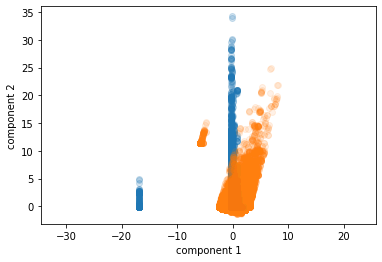

In [112]:
# Graficando o PCA
plt.scatter(X_norm[:, 0], X_norm[:, 1], alpha=0.2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.1)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.axis('equal');

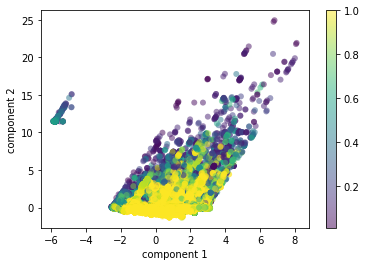

In [113]:
#colorindo os pontos de acordo com o risco de fogo, para entender se a PCA agrupou os dados de alguma maneira
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='none', alpha=0.5, c=meses["risco_fogo"].values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

In [ ]:
# Plotando gráfico 3D
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=meses['risco_fogo'].values)

In [ ]:
# Matriz de loadings, para investigar o que cada componente principal levou em conta em relação as features originais
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_pca.head()

loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

In [ ]:
# graficando a variância explicada e acumulada
def plot_variance(pca, width=8, dpi=100):
    # Criar figura
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Fazer o cálculo da variância explicada
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Componente", 
        title="Variancia explicada", 
        ylim=(0.0, 1.0)
    )
    
    # Variância acumulada
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Componente", 
        title="Variância acumulada", 
        ylim=(0.0, 1.0)
    )
    
    # Detalhes da figura
    fig.set(figwidth=8, dpi=100)
    return axs

# Graficar
plot_variance(pca)
